In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='paper')

from masterthesis.utils import load_split, round_cefr_score, DATA_DIR, CEFR_LABELS, LANG_LABELS, iso639_3, IMG_DIR
from masterthesis.models.report import report
from masterthesis.features.build_features import iterate_tokens, iterate_mixed_pos_tags, iterate_pos_tags

In [3]:
train = load_split('train')
dev = load_split('dev')
data = pd.concat([train, dev])

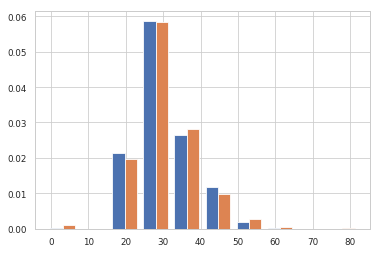

In [4]:
column = 'testlevel'
labels = data[column].unique()
vals = [data[data[column] == l].age for l in labels]
plt.hist(vals, density=True);

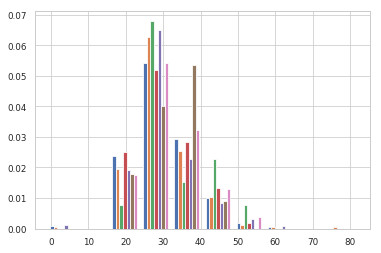

In [5]:
column = 'cefr'
labels = data[column].unique()
vals = [data[data[column] == l].age for l in labels]
plt.hist(vals, density=True);

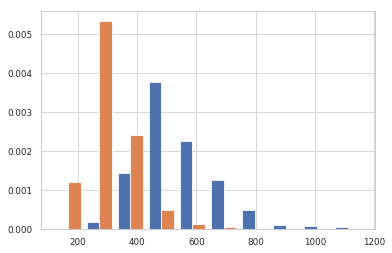

In [6]:
column = 'testlevel'
labels = data[column].unique()
vals = [data[data[column] == l].num_tokens for l in labels]
plt.hist(vals, density=True);

In [7]:
sorted(data.title.unique())

["'Import' av helsepersonell",
 'Adopsjon',
 'Alkohol og alkoholvaner',
 'Barn og fysiske aktiviteter',
 'Barndom og voksenverden',
 'Barneoppdragelse',
 'Bestselgere og bokbransjen',
 'Bilbruk',
 'Bilisme',
 'Boformer',
 'Bolig og bosted',
 'Bolig og boutgifter',
 'Bomiljø',
 'Borgerlønn',
 'Bruk av musikk',
 'Den gode skolen',
 'Den lille forskjellen',
 'Den norske naturen',
 'Det norske monarkiet',
 "Diktet 'Det er langt mellom venner' av Kolbjørn Falkeid",
 "Diktet 'Et møte' av Kolbein Falkeid",
 "Diktet 'Ingen ting' av Paulus Utsi om språk",
 "Diktet 'Mayday' av Lars Saabye Christensen",
 "Diktet 'Privat huskeregel' av Kolbjørn Falkeid",
 "Diktet 'Sannheten' av Rolf Jacobsen",
 "Diktet 'Synsvinkel' av Gunnar Øi",
 "Diktet 'Toleranse'",
 'Eldrebølgen',
 'En bok fra din kultur eller ditt hjemland',
 'En forfatter og om en bok han/ hun har skrevet',
 'En hyggelig opplevelse',
 'En interesse du har',
 'En kjent person',
 'En person som har betydd mye for deg',
 'Enpersons-husholdninge

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

In [9]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train.num_tokens.values.reshape(-1, 1))
dev_x = scaler.transform(dev.num_tokens.values.reshape(-1, 1))

/home/stig/master-thesis/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
clf = LogisticRegression()
clf.fit(train_x, train.cefr)
pred = clf.predict(dev_x)
print("Macro f1: %.3f" % f1_score(dev.cefr, pred, average='macro'))
print("Weighted f1: %.3f" % f1_score(dev.cefr, pred, average='weighted'))
print("Accuracy: %.3f" % accuracy_score(dev.cefr, pred))
print(classification_report(dev.cefr, pred))

Macro f1: 0.149
Weighted f1: 0.256
Accuracy: 0.390
             precision    recall  f1-score   support

         A2       0.00      0.00      0.00         1
      A2/B1       0.00      0.00      0.00        22
         B1       0.28      0.85      0.42        20
      B1/B2       0.00      0.00      0.00        30
         B2       0.49      0.84      0.62        37
      B2/C1       0.00      0.00      0.00        10
         C1       0.00      0.00      0.00         3

avg / total       0.19      0.39      0.26       123



/home/stig/master-thesis/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stig/master-thesis/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
clf.predict([[5]])

array(['B2'], dtype=object)

In [12]:
train['collapsed'] = [round_cefr_score(s) for s in train.cefr]
dev['collapsed'] = [round_cefr_score(s) for s in dev.cefr]

             precision    recall  f1-score   support

         A2       0.00      0.00      0.00         1
      A2/B1       0.00      0.00      0.00        22
         B1       0.16      1.00      0.28        20
      B1/B2       0.00      0.00      0.00        30
         B2       0.00      0.00      0.00        37
      B2/C1       0.00      0.00      0.00        10
         C1       0.00      0.00      0.00         3

avg / total       0.03      0.16      0.05       123

Macro F1: 0.040
Micro F1: 0.163
Weighted F1: 0.045
== Confusion matrix ==
[[ 0  0  1  0  0  0  0]
 [ 0  0 22  0  0  0  0]
 [ 0  0 20  0  0  0  0]
 [ 0  0 30  0  0  0  0]
 [ 0  0 37  0  0  0  0]
 [ 0  0 10  0  0  0  0]
 [ 0  0  3  0  0  0  0]]


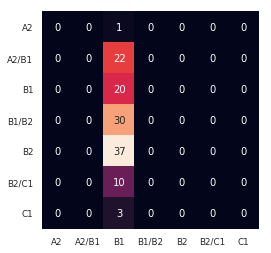

In [13]:
majority_label = train.cefr.value_counts().index[0]
pred = [majority_label for __ in dev.cefr]

labels = sorted(dev.cefr.unique())
report([labels.index(s) for s in dev.cefr],
       [labels.index(s) for s in pred],
       labels)

             precision    recall  f1-score   support

         A2       0.00      0.00      0.00         1
         B1       0.34      1.00      0.51        42
         B2       0.00      0.00      0.00        67
         C1       0.00      0.00      0.00        13

avg / total       0.12      0.34      0.17       123

Macro F1: 0.127
Micro F1: 0.341
Weighted F1: 0.174
== Confusion matrix ==
[[ 0  1  0  0]
 [ 0 42  0  0]
 [ 0 67  0  0]
 [ 0 13  0  0]]


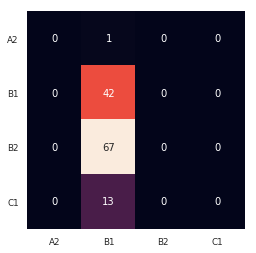

In [14]:
majority_label = train.collapsed.value_counts().index[0]
pred = [majority_label for __ in dev.collapsed]

labels = sorted(dev.collapsed.unique())
report([labels.index(s) for s in dev.collapsed],
       [labels.index(s) for s in pred],
       labels)

# How long sequences should we work with?

We want to have sequences long enough that we have enough information to make a good prediction. Using the maximum length is a simple way to decide, but if the longest document is an outlier we will use a lot of memory to pad the shorter documents.

Let's look at a few different percentiles of document length.

In [15]:
for p in [0.25, 0.5, 0.75, 0.85, 0.95, 1]:
    print('{:.2f} - {:f}'.format(p, train.num_tokens.quantile(p)))

0.25 - 263.250000
0.50 - 356.000000
0.75 - 488.000000
0.85 - 560.250000
0.95 - 700.500000
1.00 - 1163.000000


The longest document is 1163 tokens, more than three times as long as the median document. The 95th percentile is less than twice the length of the median document and thus seems like a good choice. Let's compare it to the median + 1.5 * IQR (interquartile range), a common cutoff for outliers:

In [16]:
s = train.num_tokens
iqr = s.quantile(0.75) - s.quantile(0.25)
print('IQR = %f' % iqr)
print('q2 + 1.5 * IQR = %f' % (s.quantile(0.5) + 1.5 * iqr))

IQR = 224.750000
q2 + 1.5 * IQR = 693.125000


In [17]:
m = s.mean()
std = s.std()
print(m)
print(std)
print(m + 2 * std)

391.8944099378882
157.6117458006055
707.1179015390992


In [18]:
meta = pd.read_csv(DATA_DIR / 'metadata.csv')
meta['isolang'] = [iso639_3.get(l, l) for l in meta.lang]
hue_order = ['train', 'dev', 'test']

Text(0,0.5,'Proportion of split (%)')

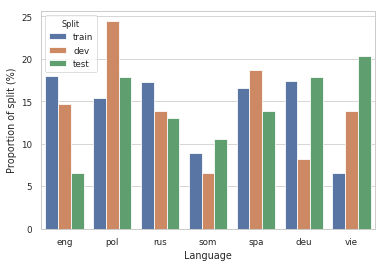

In [19]:
data = (meta.groupby('split')['isolang']
            .value_counts(normalize=True)
            .apply(lambda s: s * 100)
            .rename('Ratio')
            .reset_index()
            .rename(columns={'isolang': 'Language', 'split': 'Split'}))
ax = sns.barplot(data=data, x='Language', y='Ratio',
                 hue='Split', hue_order=hue_order, order=LANG_LABELS)
ax.set_ylabel('Proportion of split (%)')
# plt.savefig(str(IMG_DIR / 'split-lang-dist.pdf'), bbox_inches='tight')

Text(0,0.5,'Proportion of split (%)')

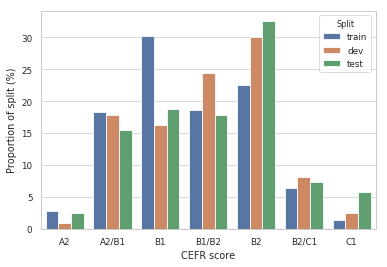

In [20]:
data = (meta.groupby('split')['cefr']
            .value_counts(normalize=True)
            .apply(lambda s: s * 100)
            .rename('Ratio')
            .reset_index()
            .rename(columns={'cefr': 'CEFR score', 'split': 'Split'}))
ax = sns.barplot(data=data, x='CEFR score', y='Ratio', hue='Split',
                 order=CEFR_LABELS, hue_order=hue_order)
ax.set_ylabel('Proportion of split (%)')
# plt.savefig(str(IMG_DIR / 'split-cefr-dist.pdf'), bbox_inches='tight')

# What is the distribution of vocabulary?

In [25]:
token_counts = Counter(iterate_tokens('train'))
total_token_count = sum(token_counts.values())
print(total_token_count)
print(sum(1 for v in token_counts.values() if v == 1))

378570
12003


In [26]:
count_counts = Counter(token_counts.values())
for n in [1, 2, 3, 4, 5, 6]:
    occuring_at_least = sum(v for k, v in count_counts.items() if k >= n)
    print('%d tokens occuring at least %d times' % (occuring_at_least, n))

20766 tokens occuring at least 1 times
8763 tokens occuring at least 2 times
5999 tokens occuring at least 3 times
4792 tokens occuring at least 4 times
4031 tokens occuring at least 5 times
3499 tokens occuring at least 6 times


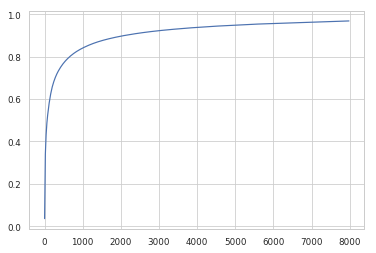

In [20]:
xs = []
ys = []
for n in range(1, 8001, 20):
    xs.append(n)
    num = sum(v for (t, v) in token_counts.most_common(n))
    ys.append(num / total_token_count)
plt.plot(xs, ys)

In [21]:
token_counts.most_common(20)

[('og', 11475),
 ('er', 11335),
 ('det', 10897),
 ('jeg', 7315),
 ('som', 5746),
 ('at', 5326),
 ('for', 5248),
 ('på', 5226),
 ('en', 5161),
 ('de', 5003),
 ('til', 4767),
 ('ikke', 4307),
 ('har', 4081),
 ('kan', 3512),
 ('med', 3506),
 ('av', 3300),
 ('vi', 3197),
 ('man', 2511),
 ('men', 2315),
 ('om', 2242)]